In [48]:
import pandas as pd
import seaborn as sns
import jsonlines

In [49]:
filename = '../logs/2020-06-08T20:41:30.715069.log'

In [50]:
def load_jsonlines(filename):
    with jsonlines.open(filename) as r:
        for obj in r:
            yield obj

In [51]:
df = pd.DataFrame.from_records(load_jsonlines(filename))

In [52]:
dfe = df[df['done']]

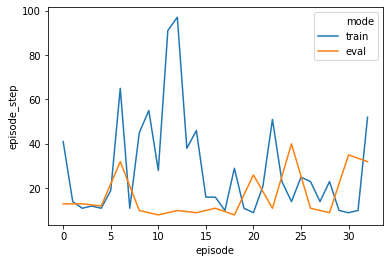

In [53]:
sns.lineplot(data=dfe, x='episode', y='episode_step', hue='mode')

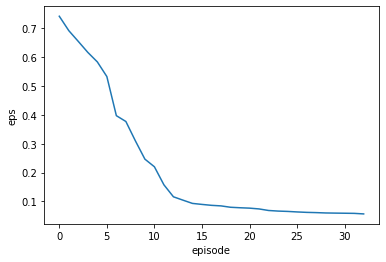

In [54]:
sns.lineplot(data=dfe[dfe['mode'] == 'train'], x='episode', y='eps')